## Imports

In [1]:
import os
import random
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedKFold
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

## Set random seed for reproducibility

In [2]:
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

## Data Loading

In [ ]:
from sklearn.model_selection import train_test_split
from collections import Counter


data_dir = "../data/balanced_data"


transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


dataset = datasets.ImageFolder(root=data_dir, transform=transform)
labels = [label for _, label in dataset.samples]


test_size = 0.1  
remaining_indices, test_indices = train_test_split(
    range(len(labels)),
    test_size=test_size,
    stratify=labels,
    random_state=SEED
)

test_dataset = Subset(dataset, test_indices)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


remaining_labels = [labels[i] for i in remaining_indices]
remaining_dataset = Subset(dataset, remaining_indices)


k_folds = 5
stratified_kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=SEED)




## Architecture Definition

In [ ]:

class ConformerTinyBinary(nn.Module):
    def __init__(self, img_size=128, num_classes=2, embed_dim=256, num_heads=8, num_transformer_layers=3, dropout=0.2):
        super(ConformerTinyBinary, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, embed_dim, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(embed_dim),
            nn.ReLU(),
            nn.Dropout2d(dropout),  

            nn.Conv2d(embed_dim, embed_dim, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(embed_dim),
            nn.ReLU(),
            nn.Dropout2d(dropout),  

            nn.Conv2d(embed_dim, embed_dim, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(embed_dim),
            nn.ReLU(),
            nn.Dropout2d(dropout)   
        )
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads),
            num_layers=num_transformer_layers
        )
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.conv(x)
        b, c, h, w = x.shape
        x = x.view(b, c, -1).permute(2, 0, 1)  
        x = self.transformer(x)
        x = x.mean(dim=0)  
        x = self.fc(x)
        return x

## Function Definition

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report
from scipy import interp

model_dir = 'scratch_test_augmentless_kfold/saved_models'
os.makedirs(model_dir, exist_ok=True)


def save_model(epoch, model, optimizer, path, best=False):
    state = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(state, path)
    
        
        

def load_model(path, model, optimizer):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    return checkpoint['epoch']


def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(dataloader.dataset)


def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()
    return running_loss / len(dataloader.dataset), correct / len(dataloader.dataset)

def custom_metric(y_true, y_pred, min_tpr=0.8):
    """
    Calculate the partial AUC (pAUC) based on a minimum TPR threshold.

    Args:
        y_true (array): True binary labels.
        y_pred (array): Predicted probabilities.
        min_tpr (float): Minimum TPR threshold (default: 0.8).

    Returns:
        float: Scaled pAUC value.
    """
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    max_fpr = 1 - min_tpr  
    v_gt = abs(y_true - 1)  
    v_pred = 1.0 - y_pred  

    
    pauc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)

    
    pauc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (pauc_scaled - 0.5)

    return pauc



def compute_auc_and_roc(model, dataloader, device, min_tpr=0.8):
    """
    Computes the ROC, AUC, and partial AUC for the given model and dataloader.
    
    Args:
        model: The PyTorch model to evaluate.
        dataloader: DataLoader for evaluation data.
        device: Device to run the computations on (CPU or GPU).
        min_tpr: Minimum TPR threshold for partial AUC computation.
    
    Returns:
        fpr: False positive rates.
        tpr: True positive rates.
        roc_auc: Full area under the ROC curve.
        partial_auc: Partial area under the ROC curve for TPR >= min_tpr.
        y_true: Ground truth labels.
        y_scores: Predicted scores for the positive class.
    """
    model.eval()
    y_true = []
    y_scores = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            
            probabilities = torch.softmax(outputs, dim=1)[:, 1]
            
            y_true.extend(labels.cpu().numpy())
            y_scores.extend(probabilities.cpu().numpy())
    
    
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = roc_auc_score(y_true, y_scores)  

    
    normalized_pauc = custom_metric(y_true, y_scores, min_tpr=min_tpr)

    return fpr, tpr, roc_auc, normalized_pauc, y_true, y_scores


## Model Init

In [ ]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


In [7]:
learning_rate = 1e-4
batch_size = 64
num_epochs = 50

## Training

In [ ]:

fold_models = []  
fold_results = []  

train_accuracies_per_fold = []
val_accuracies_per_fold = []

for fold, (train_indices, val_indices) in enumerate(stratified_kfold.split(np.zeros(len(remaining_labels)), remaining_labels)):
    print(f"Fold {fold + 1}/{k_folds}")

    train_indices = [remaining_indices[i] for i in train_indices]
    val_indices = [remaining_indices[i] for i in val_indices]

    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = ConformerTinyBinary().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_val_loss = float('inf')
    best_model_path = os.path.join(model_dir, f"best_model_fold{fold + 1}.pth")

    train_accuracies = []
    val_accuracies = []
    train_losses = []  
    val_losses = []    

    for epoch in range(num_epochs):
        
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
        _, train_acc = validate(model, train_loader, criterion, device)
        train_accuracies.append(train_acc)
        train_losses.append(train_loss)

        
        val_loss, val_acc = validate(model, val_loader, criterion, device)
        val_accuracies.append(val_acc)
        val_losses.append(val_loss)

        print(f"Fold {fold + 1}, Epoch {epoch + 1}/{num_epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            save_model(epoch, model, optimizer, best_model_path, best=True)

    
    train_accuracies_per_fold.append(train_accuracies)
    val_accuracies_per_fold.append(val_accuracies)

    
    fold_results.append({
        "fold": fold + 1,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies,
        "best_val_loss": best_val_loss
    })

    
    model.load_state_dict(torch.load(best_model_path)['model_state_dict'])
    fold_models.append(model)  


Fold 1/5


c:\Users\jonec\miniconda3\envs\general_ai\lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
c:\Users\jonec\miniconda3\envs\general_ai\lib\site-packages\torch\nn\functional.py:5560: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Fold 1, Epoch 1/50 - Train Loss: 0.7377, Train Acc: 0.4991, Val Loss: 0.8473, Val Acc: 0.5000
Fold 1, Epoch 2/50 - Train Loss: 0.6769, Train Acc: 0.5097, Val Loss: 0.7109, Val Acc: 0.5141
Fold 1, Epoch 3/50 - Train Loss: 0.6392, Train Acc: 0.5257, Val Loss: 0.7366, Val Acc: 0.5423
Fold 1, Epoch 4/50 - Train Loss: 0.6246, Train Acc: 0.5717, Val Loss: 0.6611, Val Acc: 0.5986
Fold 1, Epoch 5/50 - Train Loss: 0.6211, Train Acc: 0.5894, Val Loss: 0.6848, Val Acc: 0.6268
Fold 1, Epoch 6/50 - Train Loss: 0.6222, Train Acc: 0.7310, Val Loss: 0.5177, Val Acc: 0.7183
Fold 1, Epoch 7/50 - Train Loss: 0.5993, Train Acc: 0.7327, Val Loss: 0.4931, Val Acc: 0.7465
Fold 1, Epoch 8/50 - Train Loss: 0.5562, Train Acc: 0.7469, Val Loss: 0.4841, Val Acc: 0.7887
Fold 1, Epoch 9/50 - Train Loss: 0.5449, Train Acc: 0.7646, Val Loss: 0.5205, Val Acc: 0.7606
Fold 1, Epoch 10/50 - Train Loss: 0.5285, Train Acc: 0.7575, Val Loss: 0.5458, Val Acc: 0.7676
Fold 1, Epoch 11/50 - Train Loss: 0.5255, Train Acc: 0.7398

C:\Users\jonec\AppData\Local\Temp\ipykernel_23712\890437736.py:67: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path)['model_sta

Fold 2, Epoch 1/50 - Train Loss: 0.7511, Train Acc: 0.5434, Val Loss: 0.7753, Val Acc: 0.5000
Fold 2, Epoch 2/50 - Train Loss: 0.6795, Train Acc: 0.5469, Val Loss: 0.6736, Val Acc: 0.5775
Fold 2, Epoch 3/50 - Train Loss: 0.6464, Train Acc: 0.6301, Val Loss: 0.7019, Val Acc: 0.5563
Fold 2, Epoch 4/50 - Train Loss: 0.6062, Train Acc: 0.6867, Val Loss: 0.6156, Val Acc: 0.6690
Fold 2, Epoch 5/50 - Train Loss: 0.5953, Train Acc: 0.7080, Val Loss: 0.6267, Val Acc: 0.6972
Fold 2, Epoch 6/50 - Train Loss: 0.5716, Train Acc: 0.7274, Val Loss: 0.5636, Val Acc: 0.7394
Fold 2, Epoch 7/50 - Train Loss: 0.5693, Train Acc: 0.7398, Val Loss: 0.5702, Val Acc: 0.6972
Fold 2, Epoch 8/50 - Train Loss: 0.5434, Train Acc: 0.7823, Val Loss: 0.5307, Val Acc: 0.7535
Fold 2, Epoch 9/50 - Train Loss: 0.5439, Train Acc: 0.7522, Val Loss: 0.5401, Val Acc: 0.7183
Fold 2, Epoch 10/50 - Train Loss: 0.5059, Train Acc: 0.7770, Val Loss: 0.5416, Val Acc: 0.7394
Fold 2, Epoch 11/50 - Train Loss: 0.5032, Train Acc: 0.7717

## Testing

In [ ]:

print("\nEvaluating on the test set with all fold models...")
test_predictions = np.zeros(len(test_dataset))  
test_true_labels = []  


for model in fold_models:
    model.eval()
    fold_test_scores = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            probabilities = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()  
            fold_test_scores.extend(probabilities)

            
            if len(test_true_labels) < len(test_dataset):
                test_true_labels.extend(labels.cpu().numpy())

    
    fold_test_scores = np.array(fold_test_scores)

    if len(fold_test_scores) != len(test_dataset):
        raise ValueError(f"Model predictions length mismatch: expected {len(test_dataset)}, got {len(fold_test_scores)}")

    
    test_predictions += fold_test_scores


test_true_labels = np.array(test_true_labels)


test_predictions /= len(fold_models)

if len(test_true_labels) != len(test_predictions):
    raise ValueError("Mismatch between test labels and predictions!")


fpr, tpr, thresholds = roc_curve(test_true_labels, test_predictions)
roc_auc = roc_auc_score(test_true_labels, test_predictions)


min_tpr = 0.8  
partial_auc = custom_metric(test_true_labels, test_predictions, min_tpr=min_tpr)

y_pred = (test_predictions >= 0.5).astype(int)  

print("\nFinal Classification Report:")
print(classification_report(test_true_labels, y_pred, target_names=dataset.classes))





Evaluating on the test set with all fold models...

Final Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        40
           1       0.79      0.79      0.79        39

    accuracy                           0.80        79
   macro avg       0.80      0.80      0.80        79
weighted avg       0.80      0.80      0.80        79



## Plotting

Saved loss and accuracy plots for Fold 1 at scratch_test_augmentless_kfold/saved_models\fold_1_loss_accuracy.png
Saved loss and accuracy plots for Fold 2 at scratch_test_augmentless_kfold/saved_models\fold_2_loss_accuracy.png
Saved loss and accuracy plots for Fold 3 at scratch_test_augmentless_kfold/saved_models\fold_3_loss_accuracy.png
Saved loss and accuracy plots for Fold 4 at scratch_test_augmentless_kfold/saved_models\fold_4_loss_accuracy.png
Saved loss and accuracy plots for Fold 5 at scratch_test_augmentless_kfold/saved_models\fold_5_loss_accuracy.png
Saved ROC curve at scratch_test_augmentless_kfold/saved_models\ROC_curve_with_custom_metric.png


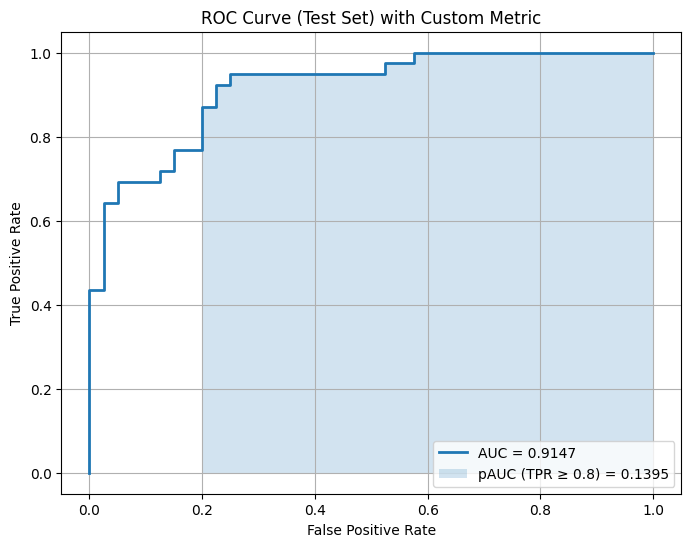

In [ ]:

for fold, (train_accuracies, val_accuracies) in enumerate(zip(train_accuracies_per_fold, val_accuracies_per_fold)):
    
    plt.figure(figsize=(12, 8))
    
    
    plt.subplot(2, 1, 1)
    train_losses = fold_results[fold].get("train_losses", [])
    val_losses = fold_results[fold].get("val_losses", [])
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss", marker='o')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss", marker='o', linestyle='--')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Fold {fold + 1}: Train vs. Validation Loss")
    plt.legend()
    plt.grid(True)

    
    plt.subplot(2, 1, 2)
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label="Train Accuracy", marker='o')
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Validation Accuracy", marker='o', linestyle='--')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"Fold {fold + 1}: Train vs. Validation Accuracy")
    plt.legend()
    plt.grid(True)

    
    fold_plot_path = os.path.join(model_dir, f"fold_{fold + 1}_loss_accuracy.png")
    plt.tight_layout()
    plt.savefig(fold_plot_path, bbox_inches="tight")
    print(f"Saved loss and accuracy plots for Fold {fold + 1} at {fold_plot_path}")
    plt.close()  


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}", linewidth=2)


partial_fpr = fpr[fpr >= 1 - min_tpr]  
partial_tpr = tpr[fpr >= 1 - min_tpr]  
plt.fill_between(partial_fpr, partial_tpr, alpha=0.2, label=f"pAUC (TPR ≥ {min_tpr:.1f}) = {partial_auc:.4f}")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Test Set) with Custom Metric")
plt.legend(loc="lower right")
plt.grid(True)

roc_curve_path = os.path.join(model_dir, "ROC_curve_with_custom_metric.png")
plt.savefig(roc_curve_path, bbox_inches="tight")
print(f"Saved ROC curve at {roc_curve_path}")
plt.show()


In [ ]:

params_file_path = os.path.join(model_dir, "model_params.txt")
with open(params_file_path, "w") as f:
    f.write("Model Architecture:\n")
    f.write(str(model) + "\n\n")  
    
    f.write("Hyperparameters:\n")
    f.write(f"Batch Size: {batch_size}\n")
    f.write(f"Learning Rate: {learning_rate}\n")
    f.write(f"Number of Epochs: {num_epochs}\n")
    f.write(f"Optimizer: Adam\n")
    f.write(f"Loss Function: CrossEntropyLoss\n")
    
print(f"Model parameters and architecture saved to {params_file_path}")


Model parameters and architecture saved to scratch_test_augmentless_kfold/saved_models\model_params.txt
